# Load Data and declarations

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
def load_ecg_data(file_path):
    signals = []
    with open(file_path, 'r') as f:
        for line in f:
            signal = list(line.strip().split('|'))
            signal = [float(x) if x else 0.0 for x in signal]
            #print(signal)
            signal.pop()
            signals.append(signal)
    
    # print(signals)
    return np.array(signals)

# Example usage
normal_train = load_ecg_data("Data\\Normal&RBBB\\Normal_Train.txt")
rbbb_train = load_ecg_data("Data\\Normal&RBBB\\RBBB_Train.txt")
normal_test = load_ecg_data("Data\\Normal&RBBB\\Normal_Test.txt")
rbbb_test = load_ecg_data("Data\\Normal&RBBB\\RBBB_Test.txt")
print(normal_test,'\n')

print("Normal Train Shape:", normal_train.shape)
print("RBBB Train Shape:", rbbb_train.shape)
print("RBBB Train Shape:", normal_test.shape)
print("RBBB Train Shape:", rbbb_test.shape)





[[-0.013701 -0.023701 -0.018701 ... -0.033701 -0.023701 -0.038701]
 [-0.023701 -0.028701 -0.038701 ... -0.063701 -0.053701 -0.038701]
 [-0.048701 -0.058701 -0.053701 ... -0.023701 -0.028701 -0.028701]
 ...
 [-0.068701 -0.043701 -0.038701 ... -0.053701 -0.058701 -0.063701]
 [-0.063701 -0.078701 -0.083701 ...  0.021299  0.006299  0.016299]
 [ 0.006299  0.016299  0.001299 ...  0.011299  0.011299  0.021299]] 

Normal Train Shape: (200, 300)
RBBB Train Shape: (200, 300)
RBBB Train Shape: (200, 300)
RBBB Train Shape: (200, 300)


# Plot some data to show the general shape

### Normal Train

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


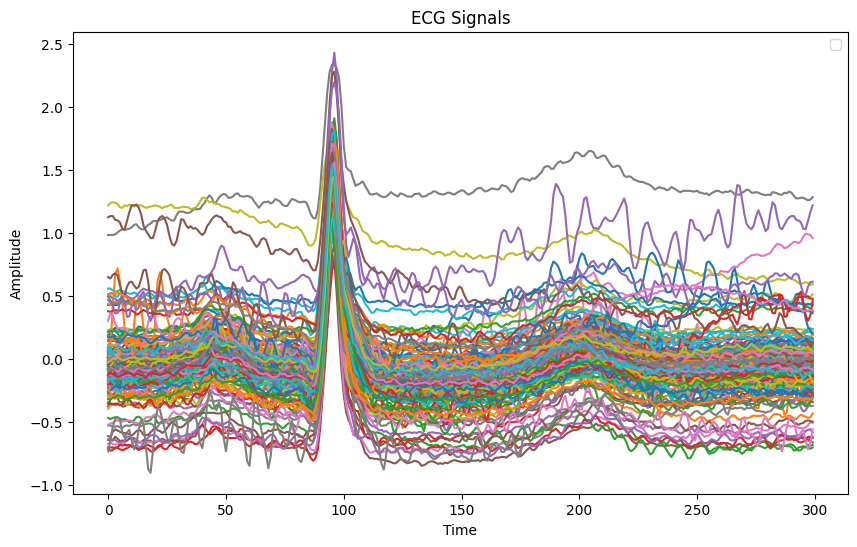

In [115]:
# Plot each row (ECG signal) in the data
plt.figure(figsize=(10, 6))

# Loop through each row in the ECG data
for i, signal in enumerate(normal_train):
    plt.plot(signal)  # Label each signal with its index

# Add title and labels
plt.title("ECG Signals")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend(loc='best')

# Show the plot
plt.show()

### RBBB train

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


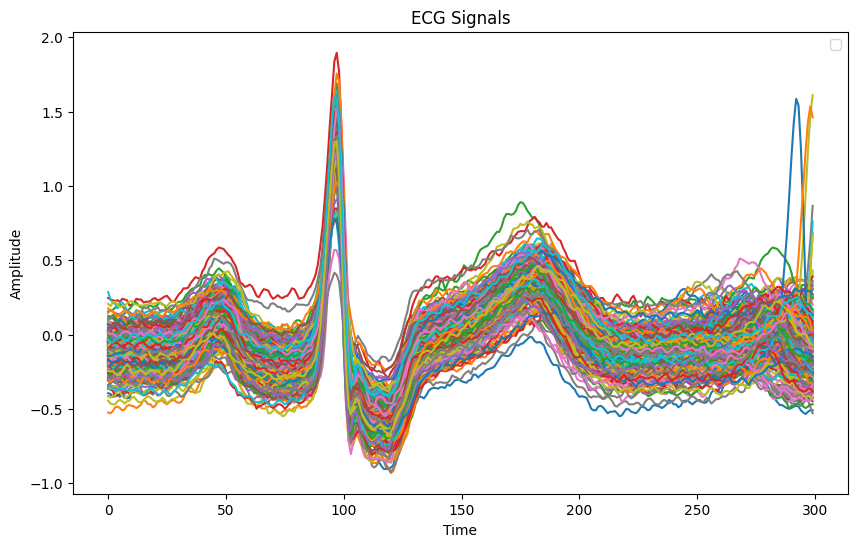

In [116]:
# Plot each row (ECG signal) in the data
plt.figure(figsize=(10, 6))

# Loop through each row in the ECG data
for i, signal in enumerate(rbbb_train):
    plt.plot(signal)  # Label each signal with its index

# Add title and labels
plt.title("ECG Signals")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend(loc='best')

# Show the plot
plt.show()

### Normal test


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


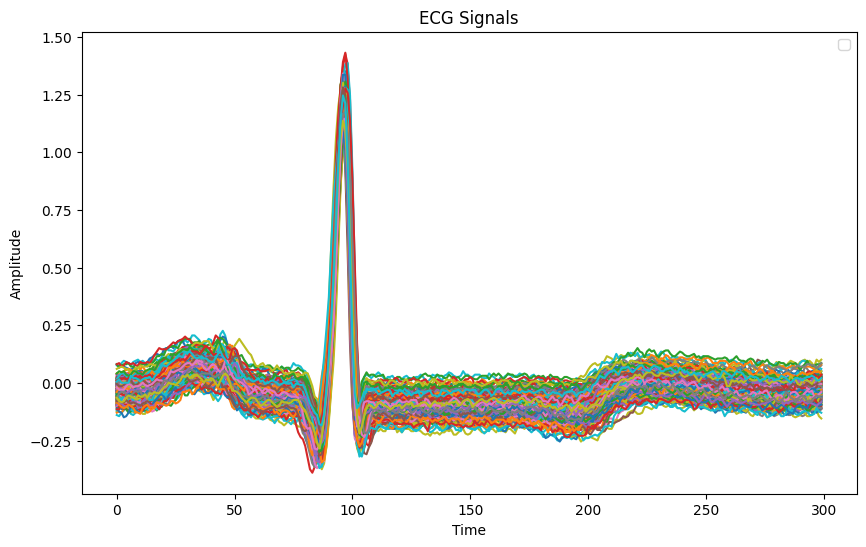

In [117]:
# Plot each row (ECG signal) in the data
plt.figure(figsize=(10, 6))

# Loop through each row in the ECG data
for i, signal in enumerate(normal_test):
    plt.plot(signal)  # Label each signal with its index

# Add title and labels
plt.title("ECG Signals")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend(loc='best')

# Show the plot
plt.show()

### RBBB TEST

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


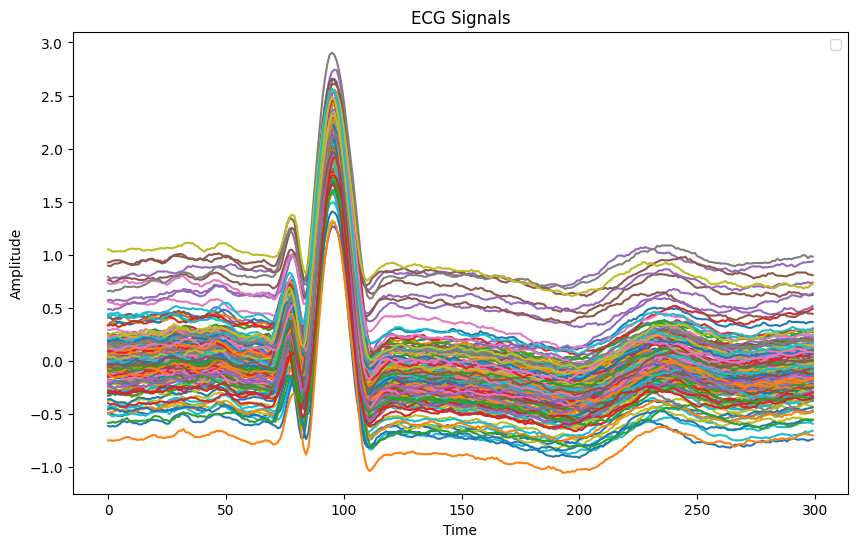

In [118]:
# Plot each row (ECG signal) in the data
plt.figure(figsize=(10, 6))

# Loop through each row in the ECG data
for i, signal in enumerate(rbbb_test):
    plt.plot(signal)  # Label each signal with its index

# Add title and labels
plt.title("ECG Signals")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend(loc='best')

# Show the plot
plt.show()

# PREPROCESSING

In [119]:

from scipy.signal import butter, filtfilt, iirnotch
# from imblearn.over_sampling import SMOTE

# Bandpass filter to remove baseline wander and high-frequency noise
def bandpass_filter(signal, lowcut=0.5, highcut=40, fs=360):
    nyquist = 0.5 * fs
    b, a = butter(4, [lowcut / nyquist, highcut / nyquist], btype='band')
    return filtfilt(b, a, signal)

# Notch filter to remove powerline interference
def notch_filter(signal, fs=360, freq=50):
    nyquist = 0.5 * fs
    b, a = iirnotch(freq / nyquist, Q=30)
    return filtfilt(b, a, signal)

def normalize_signal(signal, method='zscore'):
    if method == 'minmax': # 0 -> 1
        return (signal - signal.min()) / (signal.max() - signal.min())
    elif method == 'zscore':
        return (signal - signal.mean()) / signal.std()
    

def preprocess_ecg(ecg_signal, fs=360):
    ecg_signal = ecg_signal - np.mean(ecg_signal)

    ecg_signal= bandpass_filter(ecg_signal)
    ecg_signal = notch_filter(ecg_signal)
    ecg_signal = normalize_signal(ecg_signal)

    return ecg_signal
    


# Fueture EXtraction

In [120]:
import numpy as np

def extract_wavelet_features(signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    features = []
    for coeff in coeffs:
        features.append(np.sum(np.square(coeff)))  # Energy
        features.append(-np.sum(coeff * np.log2(np.abs(coeff) + 1e-6)))  # Entropy
    return np.array(features)


# Training and testing

### KNN

In [121]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

# Preprocess the signals
normal_train_preprocessed = preprocess_ecg(normal_train)
normal_test_preprocessed = preprocess_ecg(normal_test)
rbbb_train_preprocessed = preprocess_ecg(rbbb_train)
rbbb_test_preprocessed = preprocess_ecg(rbbb_test)

# Extract features for each sample in the training and test sets
normal_train_features = np.array([extract_wavelet_features(signal) for signal in normal_train_preprocessed])
normal_test_features = np.array([extract_wavelet_features(signal) for signal in normal_test_preprocessed])
rbbb_train_features = np.array([extract_wavelet_features(signal) for signal in rbbb_train_preprocessed])
rbbb_test_features = np.array([extract_wavelet_features(signal) for signal in rbbb_test_preprocessed])

# print(len(normal_train_features))
# print(len(rbbb_train_features))

# Combine the features and labels
X_train = np.vstack([normal_train_features, rbbb_train_features])
y_train = np.hstack([np.zeros(len(normal_train_features)), np.ones(len(rbbb_train_features))])
X_test = np.vstack([normal_test_features, rbbb_test_features])
y_test = np.hstack([np.zeros(len(normal_test_features)), np.ones(len(rbbb_test_features))])

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

# Train the k-NN classifier
knn = KNeighborsClassifier(
    n_neighbors=15,        # use odd number to avoid ties in binary classification, low n overfitting, high n underfitting
    weights='distance',    # Weight by inverse of distance
    algorithm='auto',      # Let Scikit-learn choose the best algorithm
    metric='cosine',    
    n_jobs=-1              # Use all available CPU cores
)
knn.fit(X_train, y_train)

# Test the classifier
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Assuming you have your true labels `y_test` and predicted labels `y_pred`
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}')

# Check accuracy on training and testing data
train_accuracy = knn.score(X_train, y_train)
test_accuracy = knn.score(X_test, y_test)

print(f"Training accuracy: {train_accuracy * 100:.2f}%")
print(f"Testing accuracy: {test_accuracy * 100:.2f}%")



Accuracy: 99.75%
Precision: 1.00, Recall: 1.00, F1-Score: 1.00
Training accuracy: 100.00%
Testing accuracy: 99.75%


### SVM

In [ ]:
# to be added

### Random forest

In [ ]:
# to be added

### Logistic regression

In [ ]:
# to be added

# Visuals and facts

### Learning Curve

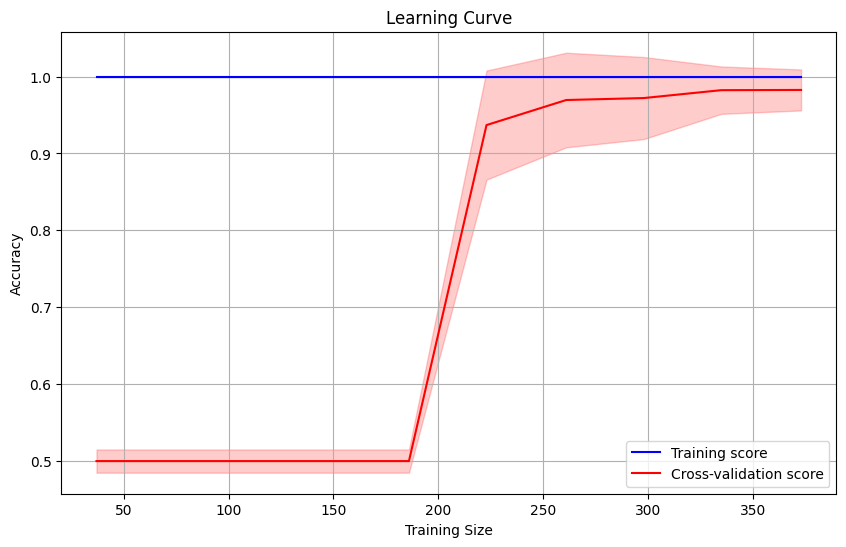

In [127]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Function to plot learning curve
def plot_learning_curve(estimator, X, y, title="Learning Curve", cv=15, n_jobs=-1):
    # Generate learning curve data
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, 
                                                            train_sizes=np.linspace(0.1, 1.0, 10))
    
    # Calculate mean and standard deviation of training and testing scores
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    test_mean = test_scores.mean(axis=1)
    test_std = test_scores.std(axis=1)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label="Training score", color="blue")
    plt.plot(train_sizes, test_mean, label="Cross-validation score", color="red")
    
    # Fill between the curves for better visualization
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="red")

    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Now call the function to generate the learning curve for your k-NN model
knn = KNeighborsClassifier(
    n_neighbors=15,        
    weights='distance',    
    algorithm='auto',      
    metric='cosine',    
    n_jobs=-1             
)

# Plot the learning curve
plot_learning_curve(knn, X_train, y_train)


### raw and preprocessed signal

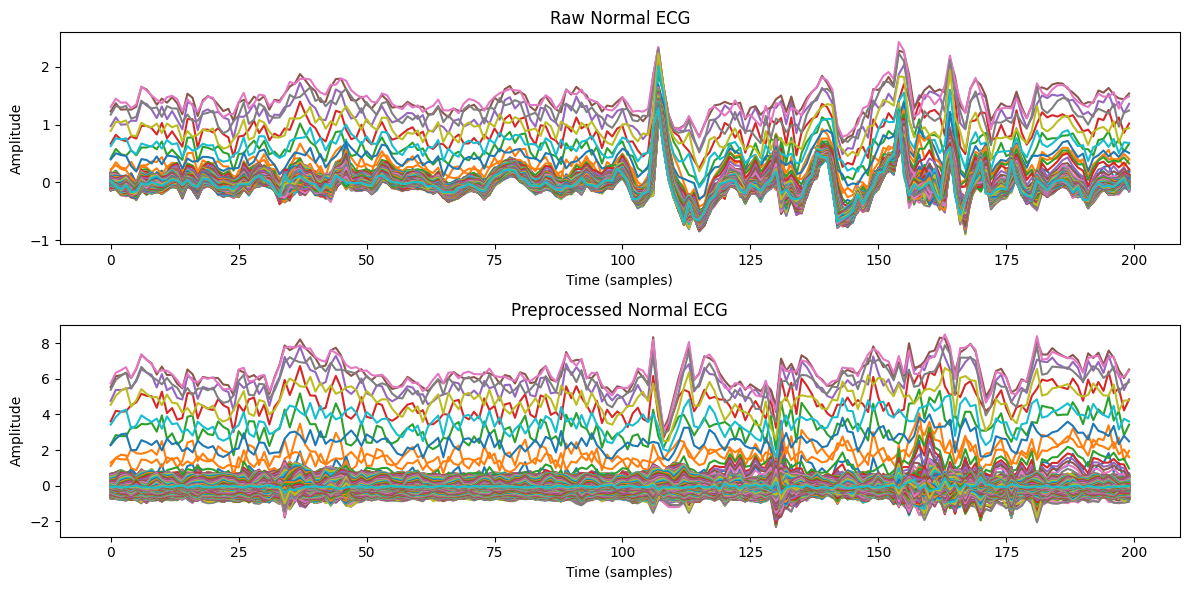

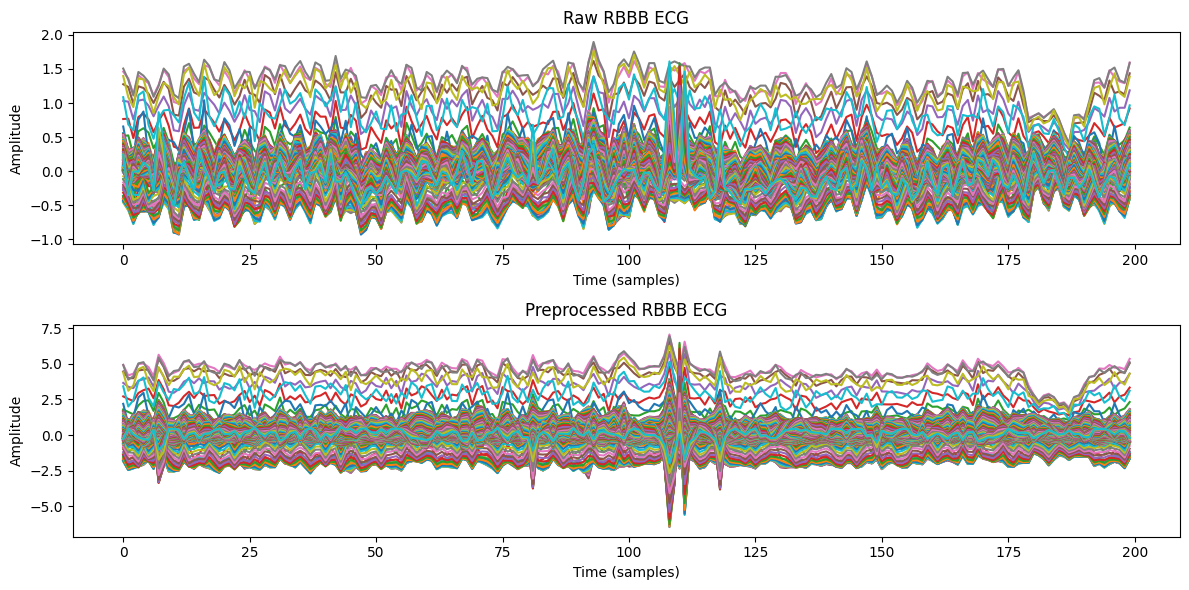

In [123]:
def plot_ecg_signals(raw_signal, preprocessed_signal, title='ECG Signal'):
    plt.figure(figsize=(12, 6))
    
    # Plot the raw signal
    plt.subplot(2, 1, 1)
    plt.plot(raw_signal)
    plt.title(f'Raw {title}')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    
    # Plot the preprocessed signal
    plt.subplot(2, 1, 2)
    plt.plot(preprocessed_signal)
    plt.title(f'Preprocessed {title}')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()

plot_ecg_signals(normal_train[:1000], normal_train_preprocessed[:1000], title='Normal ECG')
plot_ecg_signals(rbbb_train[:1000], rbbb_train_preprocessed[:1000], title='RBBB ECG')

### Confusion Matrix

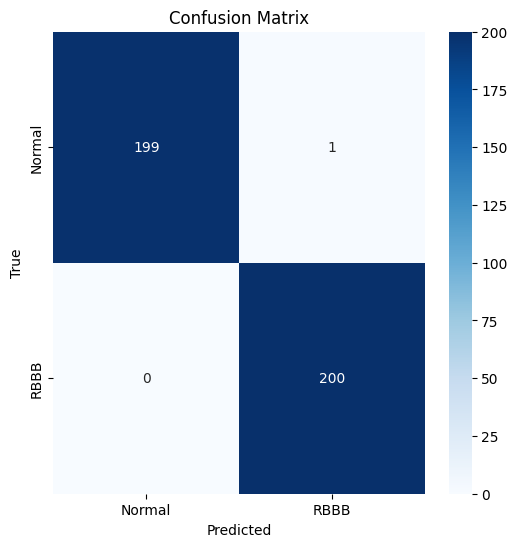

In [128]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'RBBB'], yticklabels=['Normal', 'RBBB'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Example: Plot confusion matrix for the test set
plot_confusion_matrix(y_test, y_pred)


# Class distribute

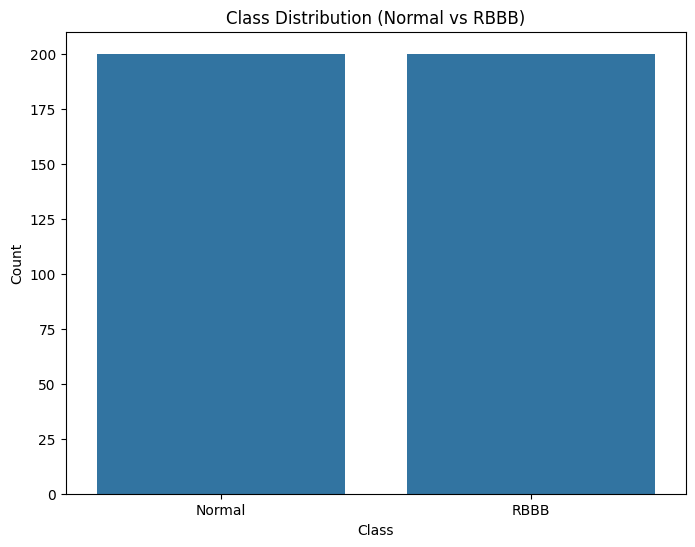

In [125]:
import seaborn as sns

# Assuming y_train contains the target labels (0 for Normal, 1 for RBBB)
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train)  # Plot count of Normal (0) vs RBBB (1)
plt.title('Class Distribution (Normal vs RBBB)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Normal', 'RBBB'])
plt.show()


# Fueture distrib

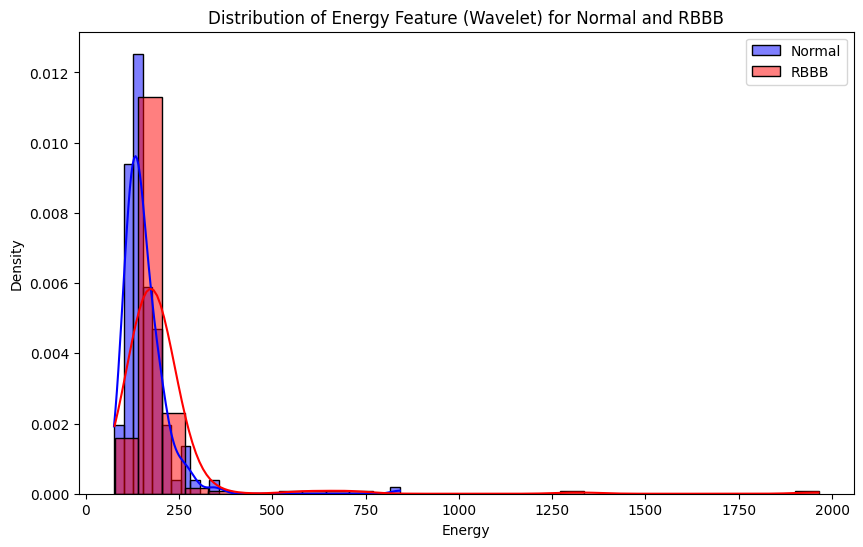

In [129]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Selecting a subset of features to visualize
# You can visualize a single feature or a set of features here.

# Flatten the feature arrays into 1D for easier plotting
normal_train_features_flat = np.array([feature for features in normal_train_features for feature in features])
rbbb_train_features_flat = np.array([feature for features in rbbb_train_features for feature in features])

# Select one feature (for example, 'energy' from wavelet decomposition)
# Here we'll assume that the 'energy' feature is the first feature in each extracted feature vector.
# This is an example; you may want to select another feature based on your analysis.
normal_energy = [features[0] for features in normal_train_features]  # energy is at index 0
rbbb_energy = [features[0] for features in rbbb_train_features]  # energy is at index 0

# Plot the distribution of the first feature (energy) for both classes
plt.figure(figsize=(10, 6))
sns.histplot(normal_energy, kde=True, color='blue', label='Normal', stat='density', bins=30)
sns.histplot(rbbb_energy, kde=True, color='red', label='RBBB', stat='density', bins=30)
plt.title('Distribution of Energy Feature (Wavelet) for Normal and RBBB')
plt.xlabel('Energy')
plt.ylabel('Density')
plt.legend()
plt.show()

# You can repeat this for other features by accessing the indices of each feature.
